<h3><b>Importing required dependencies</b></h3>

In [2]:
import tempfile

# Create a temporary directory on D drive
temp_dir = tempfile.mkdtemp(dir='D:/temp')

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle #for saving history object
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.xception import preprocess_input  # Adjusted import for Xception
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from datetime import datetime

In [2]:
# Check available GPUs
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Print information about each GPU
    for gpu in gpus:
        print("Name:", gpu.name)
        print("Type:", gpu.device_type)
else:
    print("No GPU available, using CPU instead")


Name: /physical_device:GPU:0
Type: GPU


<h3><b>Data Preprocessing</b></h3>

In [2]:
train_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
val_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
test_dir = 'D:/testproject/New Plant Diseases Dataset(Augmented)/test/test'


(256, 256, 3)


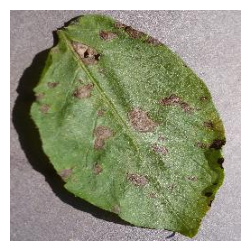

In [4]:
image_path = r'D:\testproject\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train\Potato___Early_blight\b549ab3b-06f1-45ef-bf34-86071552d870___RS_Early.B 8576_180deg.JPG'

# Read the image
img = plt.imread(image_path)

print(img.shape)
plt.figure(figsize=(3,3))
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [5]:
image_path = r'D:\testproject\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train\Potato___Early_blight\b549ab3b-06f1-45ef-bf34-86071552d870___RS_Early.B 8576_180deg.JPG'

# Read the image
img = plt.imread(image_path)

print(img)

[[[145 134 138]
  [147 136 140]
  [153 142 146]
  ...
  [197 191 193]
  [197 191 193]
  [193 187 189]]

 [[162 151 155]
  [152 141 145]
  [141 130 134]
  ...
  [177 171 173]
  [178 172 174]
  [180 174 176]]

 [[151 140 144]
  [145 134 138]
  [141 130 134]
  ...
  [180 174 176]
  [185 179 181]
  [190 184 186]]

 ...

 [[125 119 123]
  [129 123 127]
  [131 125 129]
  ...
  [192 187 193]
  [195 190 196]
  [202 197 203]]

 [[127 121 125]
  [135 129 133]
  [134 128 132]
  ...
  [180 175 181]
  [188 183 189]
  [188 183 189]]

 [[127 121 125]
  [147 141 145]
  [150 144 148]
  ...
  [177 172 178]
  [191 186 192]
  [189 184 190]]]


In [3]:
#Image and train parameters
epochs = 20
patience = 5
img_size = (299, 299) 
batch_size = 16

<h3><b>Splitting of Data for Train, Validation & Test</b></h3>

In [4]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input 
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 12750 images belonging to 17 classes.
Found 7809 images belonging to 17 classes.
Found 468 images belonging to 17 classes.


<h3><b>Building the CNN Model</b></h3>

In [8]:
# Build the model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3)) 

In [9]:
# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False


model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])


In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


<h3><b>Model Training</b></h3>

In [11]:
base_model_name = base_model.name
current_date = datetime.now().strftime("%d-%m-%Y")
file_name = f"models/{base_model_name}_plant_disease_detection[{current_date}].h5"
if os.path.exists(file_name):
    print(file_name, "already exists!!")
    option = input("A file with the same name already exists.  (1) Enter a new name  (2) Continue with the existing name?  Enter 1 or 2: ")
    if option == "1":
        new_name = input("Please enter a new name: ")
        file_name = f"models/{new_name}.h5"
        print("New file name: ", file_name)
    elif option == "2":
        print("Continuing with the existing name.\n",file_name)
    else:
        print("Invalid option. Continuing with the existing name.")
else:
    print("New file name: ", file_name)

# Define callbacks
checkpoint = ModelCheckpoint(file_name, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

models/xception_plant_disease_detection[02-04-2024].h5 already exists!!
Continuing with the existing name.
 models/xception_plant_disease_detection[02-04-2024].h5


In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping] 
)

Epoch 1/20
796/796 [==============================] - ETA: 0s - loss: 1.0814 - accuracy: 0.6561
Epoch 1: val_accuracy improved from -inf to 0.88051, saving model to models\xception_plant_disease_detection[02-04-2024].h5
796/796 [==============================] - 313s 381ms/step - loss: 1.0814 - accuracy: 0.6561 - val_loss: 0.3755 - val_accuracy: 0.8805
Epoch 2/20
796/796 [==============================] - ETA: 0s - loss: 0.6477 - accuracy: 0.7900
Epoch 2: val_accuracy improved from 0.88051 to 0.88384, saving model to models\xception_plant_disease_detection[02-04-2024].h5
796/796 [==============================] - 293s 367ms/step - loss: 0.6477 - accuracy: 0.7900 - val_loss: 0.3738 - val_accuracy: 0.8838
Epoch 3/20
796/796 [==============================] - ETA: 0s - loss: 0.5370 - accuracy: 0.8222
Epoch 3: val_accuracy improved from 0.88384 to 0.88781, saving model to models\xception_plant_disease_detection[02-04-2024].h5
796/796 [==============================] - 295s 370ms/step - los

In [5]:
# Load model
model = load_model('../models/xception_plant_disease_detection[02-04-2024].h5')

In [ ]:
# Save history object
with open('../otherfiles/history[xception02042024].pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [12]:

# Load history object
with open('../otherfiles/history[xception02042024].pkl', 'rb') as f:
    loaded_history = pickle.load(f)


<h3><b>Evaluation of Model</b></h3>

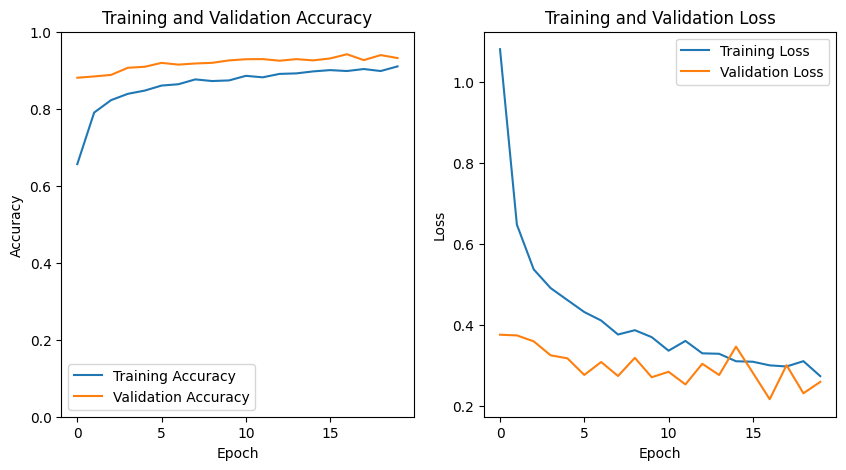

In [13]:
# Plot training history 
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(loaded_history['loss'], label='Training Loss')
#plt.plot(history.history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

30/30 [==============================] - 7s 183ms/step
There were 18 errors in 468 tests for an accuracy of 96.15


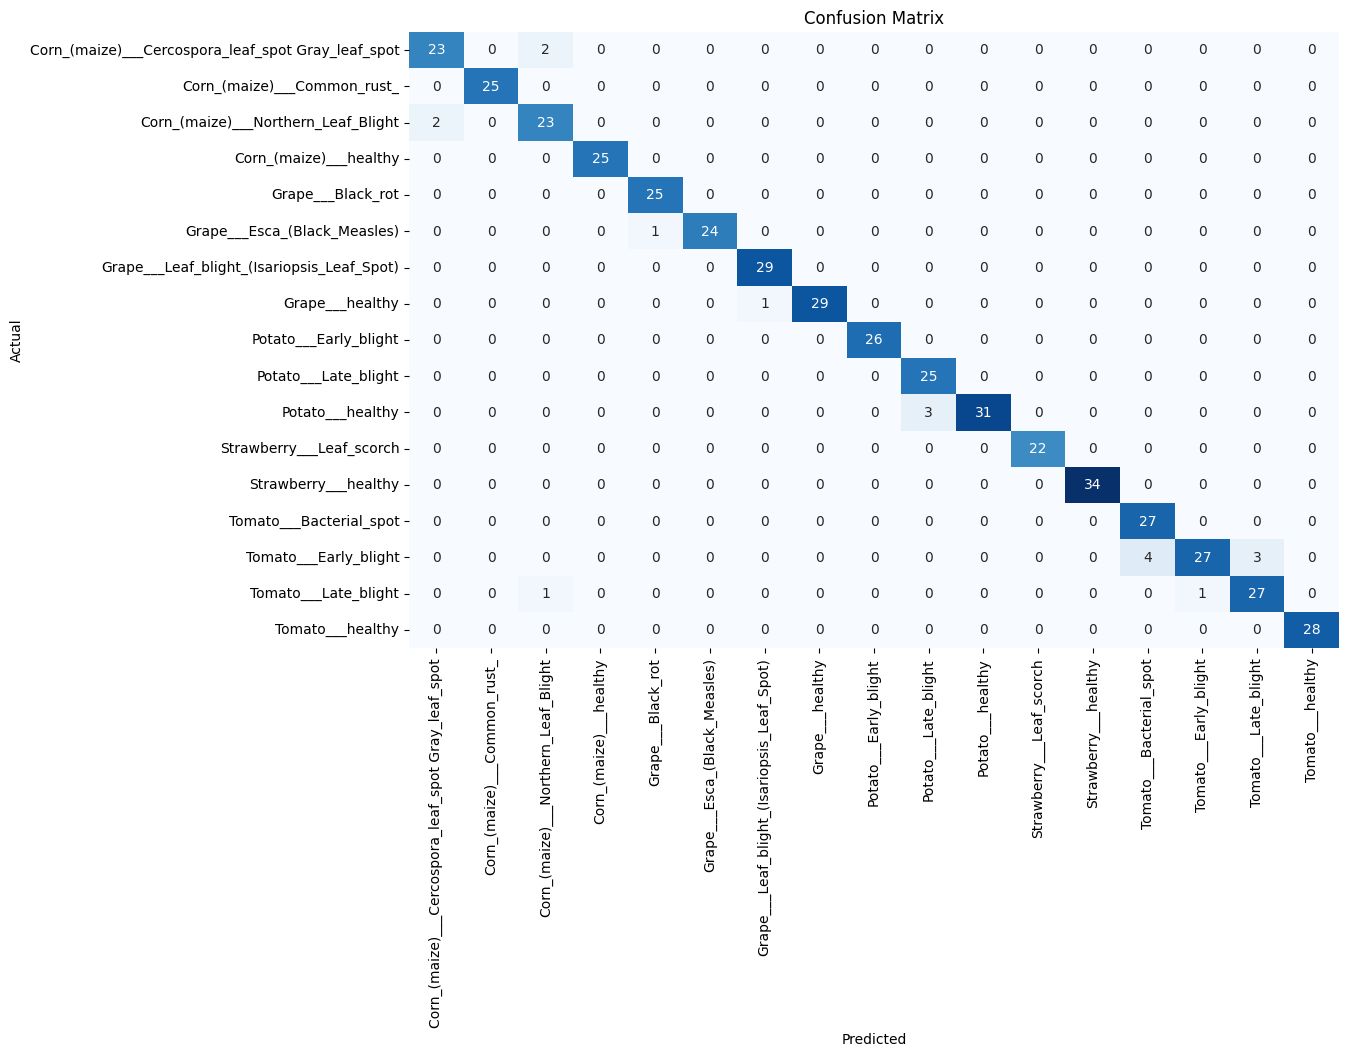

Classification Report:
----------------------
                                                     precision    recall  f1-score   support

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9200    0.9200    0.9200        25
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000        25
               Corn_(maize)___Northern_Leaf_Blight     0.8846    0.9200    0.9020        25
                            Corn_(maize)___healthy     1.0000    1.0000    1.0000        25
                                 Grape___Black_rot     0.9615    1.0000    0.9804        25
                      Grape___Esca_(Black_Measles)     1.0000    0.9600    0.9796        25
        Grape___Leaf_blight_(Isariopsis_Leaf_Spot)     0.9667    1.0000    0.9831        29
                                   Grape___healthy     1.0000    0.9667    0.9831        30
                             Potato___Early_blight     1.0000    1.0000    1.0000        26
                              Po

In [7]:
def predictor(test_gen):    
    y_pred = []
    error_list = []
    error_pred_list = []
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)    
    for i, p in enumerate(preds):        
        pred_index = np.argmax(p)         
        true_index = test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors = errors + 1
            file = test_gen.filenames[i]
            error_list.append(file)
            error_class = classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc = (1 - errors/tests) * 100
    msg = f'There were {errors} errors in {tests} tests for an accuracy of {acc:.2f}'
    print(msg)
    
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100
    if class_count <= 30:
        cm = confusion_matrix(ytrue, ypred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    
    return errors, tests, error_list, error_pred_list, f1score, y_pred, y_true

errors, tests, error_list, error_pred_list, f1score, y_pred, y_true = predictor(test_generator)

In [6]:
# Evaluate the model on test generator
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)


30/30 [==============================] - 16s 209ms/step - loss: 0.1319 - accuracy: 0.9615
Test Accuracy: 0.9615384340286255
Test Loss: 0.13185416162014008


30/30 [==============================] - 6s 191ms/step


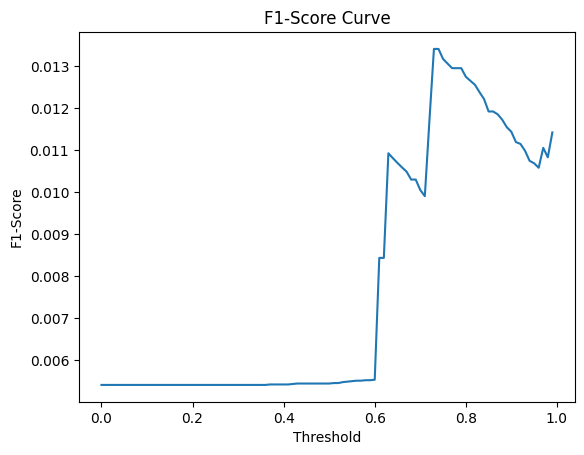

In [11]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have y_true (true labels) and y_pred (predicted probabilities)
y_true = test_generator.labels
y_pred = model.predict(test_generator)

thresholds = np.arange(0.0, 1.0, 0.01)  # Adjust the step size as needed
f1_scores = []
for threshold in thresholds:
    y_pred_thresholded = (y_pred.max(axis=1) > threshold).astype(int)
    f1_scores.append(f1_score(y_true, y_pred_thresholded, average='weighted'))

# Plot the F1-score curve
plt.figure()
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score Curve')
plt.show()

30/30 [==============================] - 6s 192ms/step


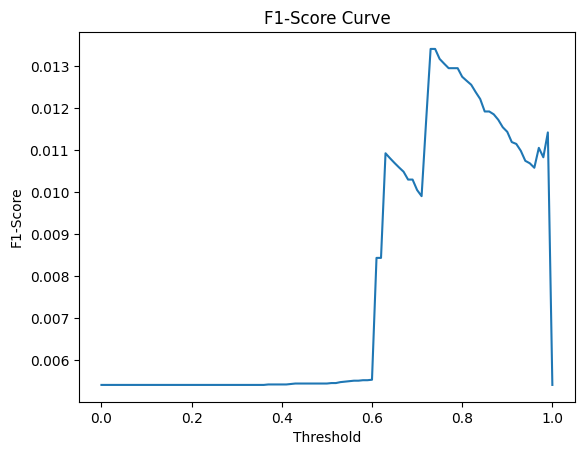

In [12]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have y_true (true labels) and y_pred (predicted probabilities)
y_true = test_generator.labels
y_pred = model.predict(test_generator)

# Adjust the threshold step size for your project
thresholds = np.linspace(0.0, 1.0, 101)  # 101 steps from 0.0 to 1.0

f1_scores = []
for threshold in thresholds:
    y_pred_thresholded = (y_pred.max(axis=1) > threshold).astype(int)
    f1_scores.append(f1_score(y_true, y_pred_thresholded, average='weighted'))

# Plot the F1-score curve
plt.figure()
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score Curve')
plt.show()

30/30 [==============================] - 6s 194ms/step


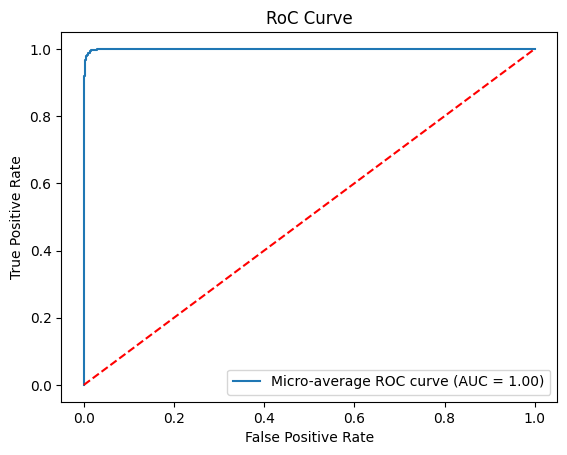

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have y_true (true labels) and y_pred (predicted probabilities)
y_true = test_generator.labels
y_pred = model.predict(test_generator)

n_classes = len(np.unique(y_true))  # Number of unique classes

# Binarize the labels
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RoC Curve')
plt.legend(loc='lower right')
plt.show()


30/30 [==============================] - 6s 189ms/step


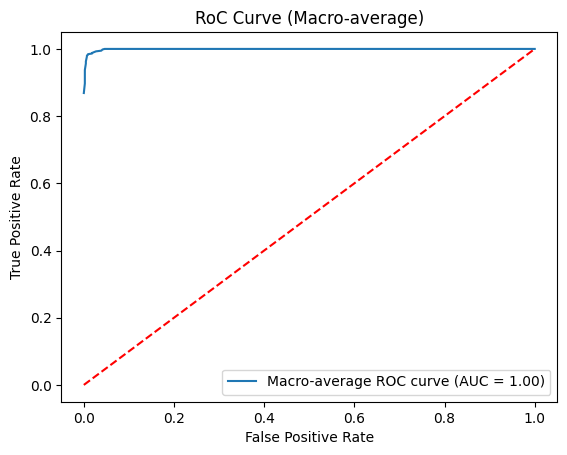

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have y_true (true labels) and y_pred (predicted probabilities)
y_true = test_generator.labels
y_pred = model.predict(test_generator)

n_classes = len(np.unique(y_true))  # Number of unique classes

# Compute macro-average ROC curve and ROC area
fpr_macro = dict()
tpr_macro = dict()
roc_auc_macro = dict()

for i in range(n_classes):
    # Convert true labels to binary for the current class
    y_true_class = np.where(y_true == i, 1, 0)
    
    # Compute ROC curve for the current class
    fpr_macro[i], tpr_macro[i], _ = roc_curve(y_true_class, y_pred[:, i])
    
    # Compute ROC AUC for the current class
    roc_auc_macro[i] = auc(fpr_macro[i], tpr_macro[i])

# Compute macro-average ROC curve by averaging all classes
all_fpr = np.unique(np.concatenate([fpr_macro[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_macro[i], tpr_macro[i])

mean_tpr /= n_classes

fpr_macro["macro"] = all_fpr
tpr_macro["macro"] = mean_tpr
roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

# Plot macro-average ROC curve
plt.figure()
plt.plot(fpr_macro["macro"], tpr_macro["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc_macro["macro"]:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RoC Curve (Macro-average)')
plt.legend(loc='lower right')
plt.show()


30/30 [==============================] - 6s 189ms/step


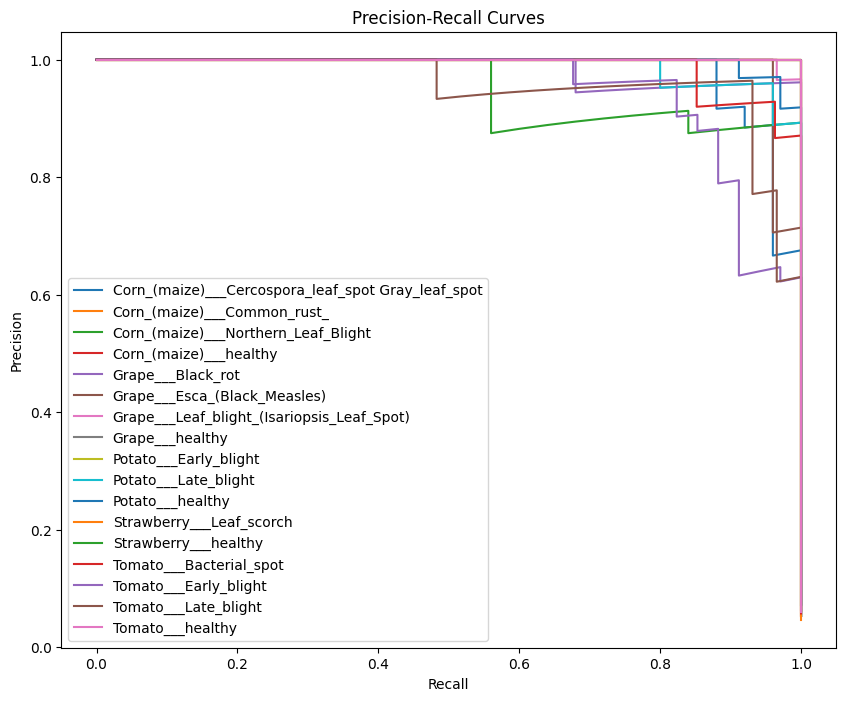

In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assuming you have y_true (true labels) and y_pred (predicted probabilities)
y_true = test_generator.labels
y_pred = model.predict(test_generator)

n_classes = len(test_generator.class_indices)
precision = dict()
recall = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred[:, i])

# Plot the Precision-Recall curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    class_name = list(test_generator.class_indices.keys())[list(test_generator.class_indices.values()).index(i)]
    plt.plot(recall[i], precision[i], label=f'{class_name}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

In [18]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

# Save class indices to a JSON file
with open('class_indices_xception.json', 'w') as f:
    json.dump(class_indices, f)

<h3><b>Prediction of Disease</b></h3>

In [29]:
# Function to predict disease from an image
def predict_disease(image_path):

    img = load_img(image_path, target_size=(img_size))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)[0]
    predicted_class_index = np.argmax(prediction)
    disease = class_indices[str(predicted_class_index)]
    confidence = prediction[predicted_class_index]

    return disease, confidence 

In [28]:
# Load class indices
with open('class_indices_xception.json', 'r') as f:
    class_indices = json.load(f)

# Load remedies
with open('remedies.json', 'r') as f:
    remedies= json.load(f)

In [35]:
image_path = r'D:\testproject\New Plant Diseases Dataset(Augmented)\CornCommonRust3.JPG' 

disease, confidence = predict_disease(image_path)

print(f'Predicted Disease: {disease}, Confidence: {confidence}')

if disease.strip() in remedies:
    remedy = remedies[disease]
    print(f'Remedies: {remedy}')
else:
    print('No remedies found for this disease.')

1/1 [==============================] - 0s 34ms/step
Predicted Disease: Tomato___Late_blight, Confidence: 0.5356236696243286
Remedies: Remedies for Tomato Late Blight
